# Approccio statistico di Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import *

In [2]:
df= pd.read_pickle("../data/processed/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName,TimeStamp
494,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00,2019-11-07 12:29:06
2439,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00,2019-11-07 12:29:26
2515,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00,2019-11-07 12:29:26
2935,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00,2019-11-07 12:29:30
3239,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00,2019-11-07 12:29:32


In [7]:
#creo indice composto con spotName e TimeStamp
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

## Analisi sui valori della tensione
Da grafico delle slide (da ricreare) si nota come molte curve abbiano un calo improvviso: andremo a cercare di identificare tali curve

In [8]:
# esplodo i valori di tensione su un nuovo df: exploded_voltage
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

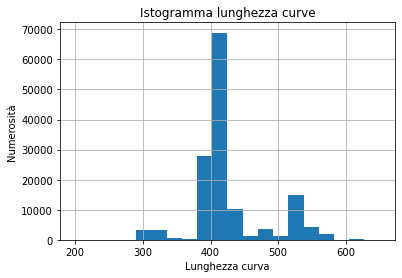

In [10]:
plt.hist(exploded_voltage.count(axis=1),bins=20,range=(200,650))
plt.xlabel('Lunghezza curva')
plt.ylabel('Numerosità')
plt.title('Istogramma lunghezza curve')
plt.grid(True);

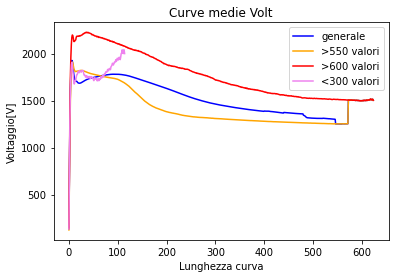

In [9]:
#plotto la curva media di tutti i valori
plt.plot(exploded_voltage.mean(axis=0),"blue",label="generale")
#plotto la curva media delle sole curve con meno di 500 rilevazioni
#plot(exploded_voltage[exploded_voltage.count(axis=1)<550].mean(axis=0),"green")
#plotto la curva media delle sole curve con più di 500 rilevazioni
plt.plot(exploded_voltage[exploded_voltage.count(axis=1)>550].mean(axis=0),"orange",label=">550 valori")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plt.plot(exploded_voltage[exploded_voltage.count(axis=1)>600].mean(axis=0),"red",label=">600 valori")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plt.plot(exploded_voltage[exploded_voltage.count(axis=1)<300].mean(axis=0),"violet",label="<300 valori")
plt.xlabel('Lunghezza curva')
plt.ylabel('Voltaggio[V]')
plt.title('Curve medie Volt')
plt.legend();

### Analisi Strutturale: picchi e cali di tensione
Voglio identificare, attraverso un approccio statistico del differenziale, quelle curve che hanno avuto un picco (o un calo) improvviso della tensione, per cui risulta un anomalia strutturale della curva stessa.

Attraverso diversi tentativi e verifiche grafiche si è optato per un differenziale di quinto ordine.

In [13]:
#calcolo il differenziale di quinto ordine tra valori successivi 
voltage_lag5=exploded_voltage.iloc[:,:624].diff(periods=5,axis=1)
#voltage_lag5.mean(axis=0).head(20)

DA RIVEDERE IL 4*x.std()

In [14]:
#creazione upper e lower limit con uso di mean e deviazion standard (mean +- 4*std)
upper_lag=voltage_lag5.apply(lambda x : x.mean()+4*x.std(),axis=0)
lower_lag=voltage_lag5.apply(lambda x : x.mean()-4*x.std(),axis=0)
#creazione upper e lower usando i quantili
upper_lag2=voltage_lag5.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_lag2=voltage_lag5.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

#### Identificazione dei dati che mostrano un calo o un picco della tensione

In [15]:
#per poter verificare se i valori rientrano o meno nelle soglie stabilite devo trattare i Null:
#sostituisco i Null in voltage_lag5 con 0 
voltage_lag5=voltage_lag5.fillna(0)

#sostituisco i Null in upper_lag con 500
upper_lag=upper_lag.fillna(500)
#sostituisco i Null in lower_lag con -500
lower_lag=lower_lag.fillna(-500)

In [16]:
#creo la colonna voltage_drop per segnalare se nella curva c'è stato un calo di tensione
exploded_voltage["voltage_drop"]=voltage_lag5.apply(lambda x : any(x<lower_lag),axis=1)
#creo la colonna voltage_drop per segnalare se nella curva c'è stato un picco di tensione
exploded_voltage["voltage_spike"]=voltage_lag5.apply(lambda x : any(x>upper_lag),axis=1)

In [17]:
#creo voltage_drops con solo curve con cali di tensione
voltage_drops=exploded_voltage[exploded_voltage["voltage_drop"]==True]
voltage_drops=voltage_drops.drop(["voltage_drop","voltage_spike"],axis=1)

In [18]:
##creo voltage_spikes con solo curve con picchi di tensione
voltage_spikes=exploded_voltage[exploded_voltage["voltage_spike"]==True]
voltage_spikes=voltage_spikes.drop(["voltage_drop","voltage_spike"],axis=1)

Esempio di detection di un calo anomalo della tensione

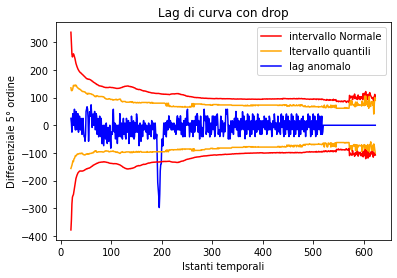

In [19]:
# plot dei differenziali e relativi range di ammissibilità
plt.plot(upper_lag[20:],"red",label="intervallo Normale")
plt.plot(upper_lag2[20:],"orange",label="Itervallo quantili")
plt.plot(voltage_lag5[any(voltage_lag5<lower_lag,axis=1)].iloc[0][20:],"blue",label="lag anomalo")
plt.plot(lower_lag2[20:],"orange")
plt.plot(lower_lag[20:],"red")
plt.xlabel('Istanti temporali')
plt.ylabel('Differenziale 5° ordine')
plt.title('Lag di curva con drop')
plt.legend();

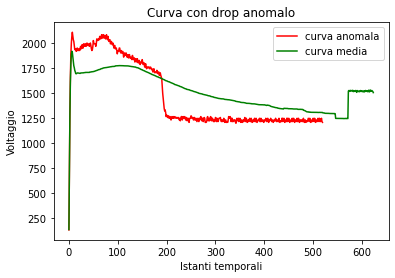

In [20]:
#curva con picco in rosso
plt.plot(voltage_drops.iloc[0],"red",label="curva anomala")
#curva media tra tutti i dati in verde
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green",label="curva media")
plt.xlabel('Istanti temporali')
plt.ylabel('Voltaggio')
plt.title('Curva con drop anomalo')
plt.legend();

Esempio di detection di un picco anomalo della tensione

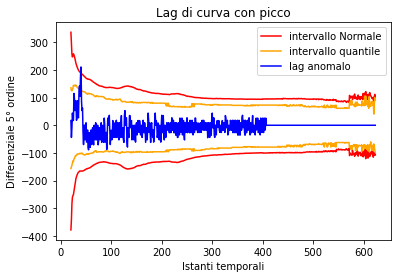

In [21]:
plt.plot(upper_lag[20:],"red",label="intervallo Normale")
plt.plot(upper_lag2[20:],"orange",label="intervallo quantile")
plot(voltage_lag5[any(voltage_lag5>upper_lag,axis=1)].iloc[1][20:],"blue",label="lag anomalo")
plt.plot(lower_lag2[20:],"orange")
plt.plot(lower_lag[20:],"red")
plt.xlabel('Istanti temporali')
plt.ylabel('Differenziale 5° ordine')
plt.title('Lag di curva con picco')
plt.legend();

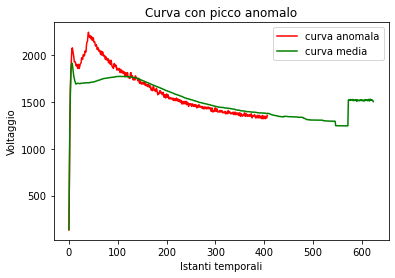

In [22]:
#curva con picco in rosso
plot(voltage_spikes.iloc[1],"red",label="curva anomala")
#curva media tra tutti i dati in verde
#plt.plot(voltage_no_drops.median(axis=0),"blue")
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green",label="curva media")
plt.xlabel('Istanti temporali')
plt.ylabel('Voltaggio')
plt.title('Curva con picco anomalo')
plt.legend();

In [23]:
#numero e percentuale di curve  che presentano drop della tensione
print(sum(exploded_voltage["voltage_drop"]==True))
print(sum(exploded_voltage["voltage_drop"]==True)/len(exploded_voltage))

27370
0.19319409053370132


In [24]:
#numero e percentuale di curve che presentano picchi della tensione
print(sum(exploded_voltage["voltage_spike"]==True))
print(sum(exploded_voltage["voltage_spike"]==True)/len(exploded_voltage))

1515
0.010693790542877512


In [25]:
len(exploded_voltage)

141671

Esempio di curva che presenta sia un picco che un calo anomalo della tensione

In [26]:
#creo both_anomalies, dataframe in cui le curve hanno sia un picco che un calo in tensione
both_anomalies=exploded_voltage[(exploded_voltage["voltage_drop"]==True) & (exploded_voltage["voltage_spike"]==True)]
both_anomalies=both_anomalies.drop(["voltage_drop","voltage_spike"],axis=1)

In [27]:
print(len(both_anomalies))
print(len(both_anomalies)/len(exploded_voltage))

713
0.005032787232390539


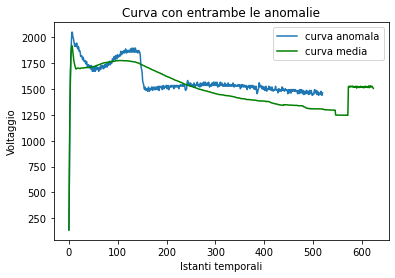

In [28]:
plt.plot(both_anomalies.iloc[56],label="curva anomala")
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green",label="curva media")
plt.xlabel('Istanti temporali')
plt.ylabel('Voltaggio')
plt.title('Curva con entrambe le anomalie')
plt.legend();

In [29]:
#aggiungo la colonna voltage_drop e voltage_spike al df originale
df=df.join(exploded_voltage[["voltage_drop","voltage_spike"]],how="left")

In [30]:
df.head()

index  \
spotName   TimeStamp                    
60000_0_00 2019-09-17 17:56:02  75938   
           2019-09-17 17:56:07  75948   
           2019-09-17 18:05:02  75984   
           2019-09-17 18:42:46  76041   
           2019-09-17 18:59:36  76063   

                                                                     VoltageCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [139, 752, 1329, 1687, 1897, 2037, 2098, 2107,...   
           2019-09-17 17:56:07  [134, 755, 1309, 1661, 1888, 2056, 2140, 2140,...   
           2019-09-17 18:05:02  [134, 758, 1298, 1652, 1897, 2065, 2124, 2124,...   
           2019-09-17 18:42:46  [138, 767, 1328, 1682, 1906, 2061, 2139, 2148,...   
           2019-09-17 18:59:36  [130, 745, 1300, 1646, 1854, 2028, 2114, 2114,...   

                                                                     CurrentCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [302, 1999, 3574, 4694, 5512, 6148, 6542, 6815...   
           2019-09-17 17:56:07  [303, 2002, 3549, 4702, 5551, 6340, 6886, 7189...   
           2019-09-17 18:05:02  [305, 2017, 3607, 4738, 5656, 6389, 6848, 7154...   
           2019-09-17 18:42:46  [333, 2033, 3641, 4795, 5614, 6312, 6767, 7040...   
           2019-09-17 18:59:36  [302, 1996, 3569, 4719, 5536, 6262, 6837, 7109...   

                                voltage_drop  voltage_spike  
spotName   TimeStamp                                         
60000_0_00 2019-09-17 17:56:02         False          False  
           2019-09-17 17:56:07         False          False  
           2019-09-17 18:05:02         False          False  
           2019-09-17 18:42:46         False          False  
           2019-09-17 18:59:36         False          False

Creo dataset con le curve di riferimento lag utilizzate:

In [40]:
reference_curves=pd.concat([upper_lag,lower_lag],keys=['upper_lag',"lower_lag"],axis=1)
reference_curves

,upper_lag,lower_lag
0,500.000000,-500.000000
1,500.000000,-500.000000
2,500.000000,-500.000000
3,500.000000,-500.000000
4,500.000000,-500.000000
...,...,...
619,101.069736,-115.536403
620,80.164662,-104.726066
621,101.137979,-100.566550
622,111.845607,-108.827425


In [41]:
#salvo in un file esterno le curve di riferimento
reference_curves.to_pickle("../data/reference/reference_volt_lag_curves.pkl")

### Anomaly detection per singoli punti
Non conosciamo la distribuzione che i dati assumono nei vari istanti temporali (anche se data la numerosità potremmo assumere una distribuzione normale). Definiamo gli outlier come:
-   The data points which fall below mean-3*(sigma) or above mean+3*(sigma) [adatta a norm]
-   The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR [adatta per dist asimettriche]

In [30]:
no_spikes=exploded_voltage[(exploded_voltage["voltage_drop"]==False) & (exploded_voltage["voltage_spike"]==False)]


In [31]:
no_spikes=no_spikes.drop(["voltage_drop","voltage_spike"],axis=1)
print(len(no_spikes)/len(exploded_voltage))
len(no_spikes)

0.8011449061558117


113499

Poichè le curve con picchi o cali anomali della tensione anomali rappresentano circa il 20% delle curve totali andrò a definire le curve di ammissione con 1.5*deviazione standard che rappresenta circa l'87% della distribuzione di una normale. Approccio quindi safe rispetto alle anomalie già trovate

In [73]:
exploded_voltage.drop(["voltage_drop","voltage_spike"],axis=1)

0    1     2     3     4     5     6     7    \
spotName   TimeStamp                                                           
60000_0_00 2019-11-07 12:29:06  132  744  1299  1663  1894  2002  2068  2110   
           2019-11-07 12:29:26  136  752  1308  1675  1923  2068  2128  2180   
           2019-11-07 12:29:26  139  757  1292  1655  1885  2042  2099  2099   
           2019-11-07 12:29:30  133  743  1286  1645  1887  2046  2104  2104   
           2019-11-07 12:29:32  137  755  1313  1683  1906  2043  2147  2189   
...                             ...  ...   ...   ...   ...   ...   ...   ...   
60001_0_00 2020-05-28 15:00:04  139  757  1292  1647  1869  2034  2099  2083   
60021_0_00 2020-05-28 15:00:04  138  777  1332  1675  1888  2008  2100  2193   
60023_0_00 2020-05-28 15:00:17  139  769  1303  1652  1853  1976  2107  2142   
60025_0_00 2020-05-28 15:00:17  134  763  1284  1602  1779  1863  1946  1972   
60027_0_00 2020-05-28 15:00:17  136  744  1264  1600  1784  1904  1944  1960   

                                 8     9    ...  614  615  616  617  618  619  \
spotName   TimeStamp                        ...                                 
60000_0_00 2019-11-07 12:29:06  2076  2035  ...  NaN  NaN  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:26  2180  2103  ...  NaN  NaN  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:26  2099  2067  ...  NaN  NaN  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:30  2129  2079  ...  NaN  NaN  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:32  2155  2104  ...  NaN  NaN  NaN  NaN  NaN  NaN   
...                              ...   ...  ...  ...  ...  ...  ...  ...  ...   
60001_0_00 2020-05-28 15:00:04  2083  2042  ...  NaN  NaN  NaN  NaN  NaN  NaN   
60021_0_00 2020-05-28 15:00:04  2193  2184  ...  NaN  NaN  NaN  NaN  NaN  NaN   
60023_0_00 2020-05-28 15:00:17  2133  2133  ...  NaN  NaN  NaN  NaN  NaN  NaN   
60025_0_00 2020-05-28 15:00:17  1955  1913  ...  NaN  NaN  NaN  NaN  NaN  NaN   
60027_0_00 2020-05-28 15:00:17  1960  1928  ...  NaN  NaN  NaN  NaN  NaN  NaN   

                                620  621  622  623  
spotName   TimeStamp                                
60000_0_00 2019-11-07 12:29:06  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:30  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:32  NaN  NaN  NaN  NaN  
...                             ...  ...  ...  ...  
60001_0_00 2020-05-28 15:00:04  NaN  NaN  NaN  NaN  
60021_0_00 2020-05-28 15:00:04  NaN  NaN  NaN  NaN  
60023_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  
60025_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  
60027_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  

[141671 rows x 624 columns]

In [64]:
#creazione upper e lower limit come per Normale (mean +- 2*std:al 95%,mean +- 3*std:al 99% )
upper_limit=exploded_voltage.drop(["voltage_drop","voltage_spike"],axis=1).apply(lambda x : x.mean()+1.5*x.std(),axis=0)
lower_limit=exploded_voltage.drop(["voltage_drop","voltage_spike"],axis=1).apply(lambda x : x.mean()-1.5*x.std(),axis=0)

Stesso discorso con i limiti percentili: andrò a considerare valori fuori norma quelli oltre il 94° percentile (o inferiore al 6° percentile)

In [77]:
#creazione upper e lower usando i quantili
#upper_limit2=no_spikes.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
#lower_limit2=no_spikes.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
upper_limit2=no_spikes.apply(lambda x : x.quantile(0.90),axis=0)
lower_limit2=no_spikes.apply(lambda x : x.quantile(0.1),axis=0)

In [78]:
#sostituisco i valori na dei range con i quantili con valori abbastanza ampi da contenere gli eventuali notNA
upper_limit2=upper_limit2.fillna(1650)
lower_limit2=lower_limit2.fillna(1350)

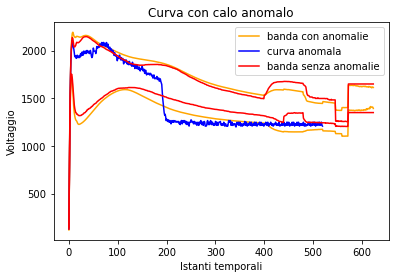

In [88]:
#plottiamo i limiti per vedere come si comportano (in arancio limiti con la std, in rosso con i percentili)
#ex particolari: 590,0,20,1
plot(upper_limit,"orange",label="banda con anomalie")
plot(lower_limit,"orange")
plot(exploded_voltage.drop(["voltage_drop","voltage_spike"],axis=1).iloc[0],"blue",label="curva anomala")
plot(upper_limit2,"red",label="banda senza anomalie")
plot(lower_limit2,"red")
plt.xlabel('Istanti temporali')
plt.ylabel('Voltaggio')
plt.title('Curva con calo anomalo')
plt.legend();

Si nota che gli itervalli costruiti tramite percentili sono leggeremente traslati verso l'alto. Decidiamo di considerare i percentili per la definizione degli outlier poichè la mediana è una misura più robusta alla presenza di outlier. 

In [36]:
media=exploded_voltage.mean()
no_nulls=exploded_voltage.fillna(media)

In [37]:
no_nulls.drop(["voltage_drop","voltage_spike"],axis=1,inplace=True)

In [38]:
#verifico se i valori di ogni curva sono all'interno dei limiti precedentemente definiti
single_outliers=no_nulls.apply(lambda x : x.between(lower_limit2,upper_limit2) ,axis=1)

In [39]:
single_outliers.iloc[0].value_counts()

False    360
True     264
Name: (60000_0_00, 2019-11-07 12:29:06), dtype: int64

In [40]:
#conta del numero di False, quindi outliers, presenti in ogni curva costruendo la colonna n_voltage_outliers
single_outliers["n_voltage_outliers"]=single_outliers.apply(lambda x : len(x)-x.sum() ,axis=1)
single_outliers

0     1     2     3      4      5      6  \
spotName   TimeStamp                                                          
60000_0_00 2019-11-07 12:29:06  True  True  True  True   True   True   True   
           2019-11-07 12:29:26  True  True  True  True  False  False  False   
           2019-11-07 12:29:26  True  True  True  True   True  False   True   
           2019-11-07 12:29:30  True  True  True  True   True  False  False   
           2019-11-07 12:29:32  True  True  True  True  False  False  False   
...                              ...   ...   ...   ...    ...    ...    ...   
60001_0_00 2020-05-28 15:00:04  True  True  True  True   True  False   True   
60021_0_00 2020-05-28 15:00:04  True  True  True  True   True   True   True   
60023_0_00 2020-05-28 15:00:17  True  True  True  True   True   True  False   
60025_0_00 2020-05-28 15:00:17  True  True  True  True   True   True   True   
60027_0_00 2020-05-28 15:00:17  True  True  True  True   True   True   True   

                                    7      8      9  ...   615   616   617  \
spotName   TimeStamp                                 ...                     
60000_0_00 2019-11-07 12:29:06   True   True   True  ...  True  True  True   
           2019-11-07 12:29:26  False  False  False  ...  True  True  True   
           2019-11-07 12:29:26   True   True   True  ...  True  True  True   
           2019-11-07 12:29:30   True  False   True  ...  True  True  True   
           2019-11-07 12:29:32  False  False  False  ...  True  True  True   
...                               ...    ...    ...  ...   ...   ...   ...   
60001_0_00 2020-05-28 15:00:04   True   True   True  ...  True  True  True   
60021_0_00 2020-05-28 15:00:04  False  False  False  ...  True  True  True   
60023_0_00 2020-05-28 15:00:17  False  False  False  ...  True  True  True   
60025_0_00 2020-05-28 15:00:17   True   True   True  ...  True  True  True   
60027_0_00 2020-05-28 15:00:17   True   True   True  ...  True  True  True   

                                 618   619   620   621   622   623  \
spotName   TimeStamp                                                 
60000_0_00 2019-11-07 12:29:06  True  True  True  True  True  True   
           2019-11-07 12:29:26  True  True  True  True  True  True   
           2019-11-07 12:29:26  True  True  True  True  True  True   
           2019-11-07 12:29:30  True  True  True  True  True  True   
           2019-11-07 12:29:32  True  True  True  True  True  True   
...                              ...   ...   ...   ...   ...   ...   
60001_0_00 2020-05-28 15:00:04  True  True  True  True  True  True   
60021_0_00 2020-05-28 15:00:04  True  True  True  True  True  True   
60023_0_00 2020-05-28 15:00:17  True  True  True  True  True  True   
60025_0_00 2020-05-28 15:00:17  True  True  True  True  True  True   
60027_0_00 2020-05-28 15:00:17  True  True  True  True  True  True   

                                n_voltage_outliers  
spotName   TimeStamp                                
60000_0_00 2019-11-07 12:29:06                 360  
           2019-11-07 12:29:26                  45  
           2019-11-07 12:29:26                  21  
           2019-11-07 12:29:30                  29  
           2019-11-07 12:29:32                  37  
...                                            ...  
60001_0_00 2020-05-28 15:00:04                  83  
60021_0_00 2020-05-28 15:00:04                  36  
60023_0_00 2020-05-28 15:00:17                  42  
60025_0_00 2020-05-28 15:00:17                   1  
60027_0_00 2020-05-28 15:00:17                   4  

[141671 rows x 625 columns]

In [41]:
len(single_outliers)

141671

In [42]:
#aggiungo la colonna n_voltage_outliers al df originale
df=df.join(single_outliers["n_voltage_outliers"],how="left")
df

index  \
spotName   TimeStamp                     
60000_0_00 2019-09-17 17:56:02   75938   
           2019-09-17 17:56:07   75948   
           2019-09-17 18:05:02   75984   
           2019-09-17 18:42:46   76041   
           2019-09-17 18:59:36   76063   
...                                ...   
60185_0_00 2020-05-06 14:06:47  221817   
           2020-05-06 14:18:28  221856   
           2020-05-27 09:15:45  222009   
           2020-05-27 09:27:57  222086   
           2020-05-27 10:18:20  222239   

                                                                     VoltageCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [139, 752, 1329, 1687, 1897, 2037, 2098, 2107,...   
           2019-09-17 17:56:07  [134, 755, 1309, 1661, 1888, 2056, 2140, 2140,...   
           2019-09-17 18:05:02  [134, 758, 1298, 1652, 1897, 2065, 2124, 2124,...   
           2019-09-17 18:42:46  [138, 767, 1328, 1682, 1906, 2061, 2139, 2148,...   
           2019-09-17 18:59:36  [130, 745, 1300, 1646, 1854, 2028, 2114, 2114,...   
...                                                                           ...   
60185_0_00 2020-05-06 14:06:47  [145, 809, 1349, 1648, 1816, 1860, 1808, 1743,...   
           2020-05-06 14:18:28  [145, 816, 1378, 1684, 1794, 1860, 1838, 1736,...   
           2020-05-27 09:15:45  [153, 813, 1356, 1657, 1825, 1869, 1818, 1759,...   
           2020-05-27 09:27:57  [149, 813, 1377, 1662, 1798, 1820, 1820, 1755,...   
           2020-05-27 10:18:20  [148, 807, 1356, 1667, 1845, 1890, 1815, 1756,...   

                                                                     CurrentCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [302, 1999, 3574, 4694, 5512, 6148, 6542, 6815...   
           2019-09-17 17:56:07  [303, 2002, 3549, 4702, 5551, 6340, 6886, 7189...   
           2019-09-17 18:05:02  [305, 2017, 3607, 4738, 5656, 6389, 6848, 7154...   
           2019-09-17 18:42:46  [333, 2033, 3641, 4795, 5614, 6312, 6767, 7040...   
           2019-09-17 18:59:36  [302, 1996, 3569, 4719, 5536, 6262, 6837, 7109...   
...                                                                           ...   
60185_0_00 2020-05-06 14:06:47  [354, 2200, 4081, 5500, 6565, 7239, 7594, 7842...   
           2020-05-06 14:18:28  [337, 2262, 4288, 5773, 6786, 7563, 8069, 8205...   
           2020-05-27 09:15:45  [337, 2193, 4116, 5499, 6512, 7220, 7490, 7726...   
           2020-05-27 09:27:57  [333, 2265, 4197, 5630, 6562, 7162, 7662, 7928...   
           2020-05-27 10:18:20  [317, 2188, 4059, 5471, 6565, 7200, 7518, 7730...   

                                voltage_drop  voltage_spike  \
spotName   TimeStamp                                          
60000_0_00 2019-09-17 17:56:02         False          False   
           2019-09-17 17:56:07         False          False   
           2019-09-17 18:05:02         False          False   
           2019-09-17 18:42:46         False          False   
           2019-09-17 18:59:36         False          False   
...                                      ...            ...   
60185_0_00 2020-05-06 14:06:47         False          False   
           2020-05-06 14:18:28         False          False   
           2020-05-27 09:15:45         False          False   
           2020-05-27 09:27:57         False          False   
           2020-05-27 10:18:20         False          False   

                                n_voltage_outliers  
spotName   TimeStamp                                
60000_0_00 2019-09-17 17:56:02                  27  
           2019-09-17 17:56:07                  29  
           2019-09-17 18:05:02                   9  
           2019-09-17 18:42:46                  30  
           2019-09-17 18:59:36                  31  
...                                            ...  
60185_0_00 2020-05-06 14:06:47

Creo colonna %volt_anomalies che mi indica la percentuale di punti anomali sul numero di punti della curva

In [43]:
df["%volt_anomalies"]=df.apply(lambda x: round(x.n_voltage_outliers/len(x.VoltageCurve)*100),axis=1)

Creo dataset con le curve di riferiment utilizzate per il voltaggio:
- curva media
- intervallo per outlier (con quantili)

In [44]:
reference_curves=pd.concat([media[:624],upper_limit2,lower_limit2],keys=['media', 'upper_limit',"lower_limit"],axis=1)
reference_curves

,media,upper_limit,lower_limit
0,134.024084,144.0,126.0
1,754.758250,796.0,732.0
2,1288.253291,1345.0,1248.0
3,1610.341199,1683.0,1544.0
4,1794.434930,1896.0,1689.0
...,...,...,...
619,1510.000000,1650.0,1350.0
620,1507.859649,1650.0,1350.0
621,1513.321429,1650.0,1350.0
622,1512.890909,1650.0,1350.0


In [45]:
#salvo in un file esterno le curve di riferimento
reference_curves.to_pickle("../data/reference/reference_volt_curves.pkl")

## Analisi sui valori della corrente
Da grafico delle slide (da ricreare) si nota come molte curve abbiano un calo improvviso: andremo a cercare di identificare tali curve

In [3]:
# esplodo i valori di tensione su un nuovo df: exploded_voltage
exploded_current=pd.DataFrame(df.CurrentCurve.tolist(), index= df.index)

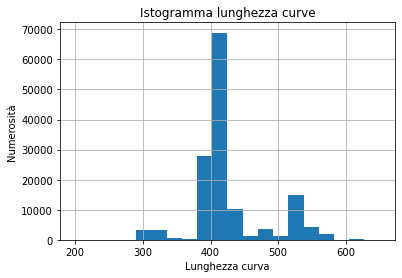

In [6]:
plt.hist(exploded_current.count(axis=1),bins=20,range=(200,650))
plt.xlabel('Lunghezza curva')
plt.ylabel('Numerosità')
plt.title('Istogramma lunghezza curve')
plt.grid(True);

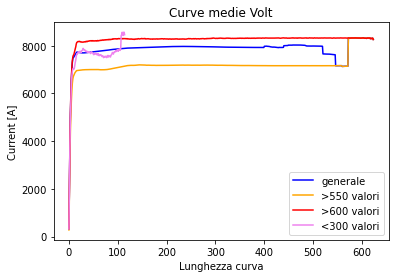

In [14]:
#plotto la curva media di tutti i valori
plot(exploded_current.mean(axis=0),"blue",label="generale")
#plotto la curva media delle sole curve con meno di 500 rilevazioni
#plot(exploded_current[exploded_current.count(axis=1)<550].mean(axis=0),"green")
#plotto la curva media delle sole curve con più di 500 rilevazioni
plot(exploded_current[exploded_current.count(axis=1)>550].mean(axis=0),"orange",label=">550 valori")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_current[exploded_current.count(axis=1)>600].mean(axis=0),"red",label=">600 valori")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_current[exploded_current.count(axis=1)<300].mean(axis=0),"violet",label="<300 valori")
plt.xlabel('Lunghezza curva')
plt.ylabel('Current [A]')
plt.title('Curve medie Volt')
plt.legend();

I valori di corrente che più sembrano discostarsi sono quelli con dimensionalità maggiore di 550

## Anomaly detection per singoli punti
Non conosciamo la distribuzione che i dati assumono nei vari istanti temporali (anche se data la numerosità potremmo assumere una distribuzione normale). Definiamo gli outlier come:
-   The data points which fall below mean-3*(sigma) or above mean+3*(sigma) [adatta a norm]
-   The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR [adatta per dist asimettriche]

In [15]:
#creazione upper e lower limit come per Normale (mean +- 2*std:al 95%,mean +- 3*std:al 99% )
upper_limit=exploded_current.apply(lambda x : x.mean()+1.5*x.std(),axis=0)
lower_limit=exploded_current.apply(lambda x : x.mean()-1.5*x.std(),axis=0)

In [50]:
#creazione upper e lower usando i quantili
upper_limit2=exploded_current.apply(lambda x : x.quantile(0.75)+1*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_limit2=exploded_current.apply(lambda x : x.quantile(0.25)-1*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

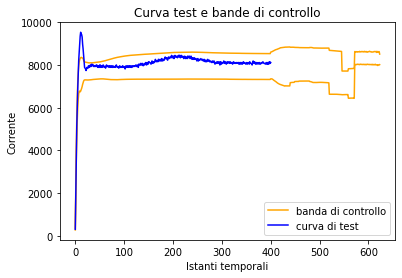

In [20]:
#plottiamo i limiti per vedere come si comportano (in arancio limiti con la std, in rosso con i percentili)
#ex particolari: 590
plt.plot(upper_limit,"orange",label="banda di controllo")
plt.plot(lower_limit,"orange")
plt.plot(exploded_current.iloc[30],"blue",label="curva di test")
plt.title("Curva test e bande di controllo")
plt.xlabel('Istanti temporali')
plt.ylabel('Corrente')
plt.legend();
#plot(upper_limit2,"red")
#plot(lower_limit2,"red")

In [52]:
media=exploded_current.mean()
no_nulls=exploded_current.fillna(media)

In [53]:
#verifico se i valori di ogni curva sono all'interno dei limiti precedentemente definiti
single_outliers=no_nulls.apply(lambda x : x.between(lower_limit,upper_limit) ,axis=1)

In [54]:
#conta del numero di False, quindi outliers, presenti in ogni curva costruendo la colonna n_voltage_outliers
single_outliers["n_current_outliers"]=single_outliers.apply(lambda x : len(x)-x.sum() ,axis=1)

In [55]:
#aggiungo la colonna n_voltage_outliers al df originale
df=df.join(single_outliers["n_current_outliers"],how="left")

Creo colonna %volt_anomalies che mi indica la percentuale di punti anomali sul numero di punti della curva

In [56]:
df["%current_anomalies"]=df.apply(lambda x: round(x.n_current_outliers/len(x.CurrentCurve)*100),axis=1)

In [57]:
df.head()

index  \
spotName   TimeStamp                    
60000_0_00 2019-09-17 17:56:02  75938   
           2019-09-17 17:56:07  75948   
           2019-09-17 18:05:02  75984   
           2019-09-17 18:42:46  76041   
           2019-09-17 18:59:36  76063   

                                                                     VoltageCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [139, 752, 1329, 1687, 1897, 2037, 2098, 2107,...   
           2019-09-17 17:56:07  [134, 755, 1309, 1661, 1888, 2056, 2140, 2140,...   
           2019-09-17 18:05:02  [134, 758, 1298, 1652, 1897, 2065, 2124, 2124,...   
           2019-09-17 18:42:46  [138, 767, 1328, 1682, 1906, 2061, 2139, 2148,...   
           2019-09-17 18:59:36  [130, 745, 1300, 1646, 1854, 2028, 2114, 2114,...   

                                                                     CurrentCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [302, 1999, 3574, 4694, 5512, 6148, 6542, 6815...   
           2019-09-17 17:56:07  [303, 2002, 3549, 4702, 5551, 6340, 6886, 7189...   
           2019-09-17 18:05:02  [305, 2017, 3607, 4738, 5656, 6389, 6848, 7154...   
           2019-09-17 18:42:46  [333, 2033, 3641, 4795, 5614, 6312, 6767, 7040...   
           2019-09-17 18:59:36  [302, 1996, 3569, 4719, 5536, 6262, 6837, 7109...   

                                voltage_drop  voltage_spike  \
spotName   TimeStamp                                          
60000_0_00 2019-09-17 17:56:02         False          False   
           2019-09-17 17:56:07         False          False   
           2019-09-17 18:05:02         False          False   
           2019-09-17 18:42:46         False          False   
           2019-09-17 18:59:36         False          False   

                                n_voltage_outliers  %volt_anomalies  \
spotName   TimeStamp                                                  
60000_0_00 2019-09-17 17:56:02                  27                6   
           2019-09-17 17:56:07                  29                7   
           2019-09-17 18:05:02                   9                2   
           2019-09-17 18:42:46                  30                7   
           2019-09-17 18:59:36                  31                7   

                                n_current_outliers  %current_anomalies  
spotName   TimeStamp                                                    
60000_0_00 2019-09-17 17:56:02                  20                   5  
           2019-09-17 17:56:07                   9                   2  
           2019-09-17 18:05:02                   0                   0  
           2019-09-17 18:42:46                   5                   1  
           2019-09-17 18:59:36                  13                   3

In [58]:
#salvo nel file with_stat_anomalies il df originario con annesse le anomalie riscontrate nelle analisi
df.to_pickle("../data/processed/with_stat_anomalies.pkl")

Creo dataset con le curve di riferimento utilizzate per la corrente:
- curva media
- intervallo per outlier

In [59]:
reference_curves=pd.concat([media[:624],upper_limit,lower_limit],keys=['media', 'upper_limit',"lower_limit"],axis=1)
reference_curves

,media,upper_limit,lower_limit
0,308.162830,346.613413,269.712248
1,2055.103136,2207.911732,1902.294541
2,3787.501590,4102.594257,3472.408924
3,5027.673480,5466.433481,4588.913478
4,5918.727630,6450.910693,5386.544568
...,...,...,...
619,8306.650000,8635.614302,7977.685698
620,8302.385965,8605.125787,7999.646143
621,8318.660714,8626.175717,8011.145711
622,8315.090909,8629.762335,8000.419484


In [60]:
#salvo in un file esterno le curve di riferimento
reference_curves.to_pickle("../data/reference/reference_current_curves.pkl")